In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import torch
from fipy_analysis import *
import logging
logging.getLogger().setLevel(logging.WARNING)

print(torch.cuda.is_available())

True


# Analysis of trained models

Right now, three models are available in the `models` subdirectory. The training configurations only differ by the hyperparameters $\alpha$, $\beta$. In a nutshell, $\alpha$ emphasizes the predictive power without the extra NN growth term, while $\beta$ emphasizes predictive power of a polynomial approximation to the NN growth term. It seems like the best predictions occur with $\alpha, \beta$ turned off, but the learned coefficients seem consistent across all three models

| Datestamp | Timestamp | $\alpha$ | $\beta$ | Grouped | $R^2$ Black | $R^2$ White |
| --------- | --------- | -------- | ------- | ------- | ----------- | ----------- |
| 200824    | 1630      | 1        | 0       | No      | 0.89        | 0.69        |
| 200824    | 1631      | 1        | 1       | No      | 0.95        | 0.68        |
| 200824    | 1632      | 0        | 0       | No      | 0.93        | 0.81        |
| 210824    | 1600      | 0        | 1       | No      | | |
| 210824    | 1556      | 0        | 0       | Yes      | | |
| 210824    | 1557      | 1        | 0       | Yes      | | |
| 210824    | 1558      | 1        | 1       | Yes      | | |
| 210824    | 1559      | 0        | 1       | Yes      | | |



In [2]:
models = sorted(glob(os.path.join("models", "*")))
models

['models/Georgia_Fulton_noGrid_SociohydroParameterNetwork_200824_1630',
 'models/Georgia_Fulton_noGrid_SociohydroParameterNetwork_200824_1631',
 'models/Georgia_Fulton_noGrid_SociohydroParameterNetwork_200824_1632',
 'models/Georgia_Fulton_noGrid_SociohydroParameterNetwork_230824_1708',
 'models/Illinois_Cook_noGrid_SociohydroParameterNetwork_220824_1435',
 'models/Illinois_Cook_noGrid_SociohydroParameterNetwork_220824_1748',
 'models/Illinois_Cook_noGrid_SociohydroParameterNetwork_230824_1659']

/project/vitelli/dsseara/schelling/jcolen/sociohydro/param_inference/fipy_analysis.py:364: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load(f"{model_dir}/mode

{'alpha': 1.0,
 'base_lr': 0.0003,
 'batch_size': 32,
 'beta': 0.0,
 'coef_lr': 0.1,
 'county': 'Illinois_Cook',
 'epochs': 100,
 'grid': False,
 'grouped': True,
 'scheduler_step': 0.98,
 'val_split': 0.5}
dt ϕW = 0.32 T_W + -2.6 k_WW + -5.2 k_WB + 2.2 ν_WWW + 5.4 ν_WWB + 2.7 ν_WBB + -1.4 Γ_W + NN(['ϕW', 'ϕB'])
dt ϕB = 0.49 T_B + 4.4 k_BB + 8.2 k_BW + 8.8 ν_BBB + -5.6 ν_BWB + -4.8 ν_BWW + -0.015 Γ_B + NN(['ϕW', 'ϕB'])
Fipy data files will be read in at runtime
gW = -0.012 1 + 0.046 ϕW + -0.096 ϕW^2
gB = 0.003 1 + -0.002 ϕB + 0.043 ϕB^2
source                  Exact  Inferred
target term                            
Black  $T_i$         1.718363  0.492028
       $\Gamma_i$    5.232607  0.014891
       $\nu_{iii}$ -32.692297 -8.842654
       $\nu_{iij}$   3.846849  5.609452
       $\nu_{ijj}$   9.856063  4.795829
       $k_{ii}$     17.419345 -4.411052
       $k_{ij}$     -9.496633 -8.215337
White  $T_i$         0.375554  0.315216
       $\Gamma_i$    2.461651  1.437990
       $\nu_{iii}

source                  Exact  Inferred
target term                            
Black  $T_i$         1.718363  0.492028
       $\Gamma_i$    5.232607  0.014891
       $\nu_{iii}$ -32.692297 -8.842654
       $\nu_{iij}$   3.846849  5.609452
       $\nu_{ijj}$   9.856063  4.795829
       $k_{ii}$     17.419345 -4.411052
       $k_{ij}$     -9.496633 -8.215337
White  $T_i$         0.375554  0.315216
       $\Gamma_i$    2.461651  1.437990
       $\nu_{iii}$  -6.400740 -2.225343
       $\nu_{iij}$ -18.906208 -5.379483
       $\nu_{ijj}$ -18.608736 -2.700095
       $k_{ii}$      7.311386  2.583662
       $k_{ij}$     15.983193  5.173746

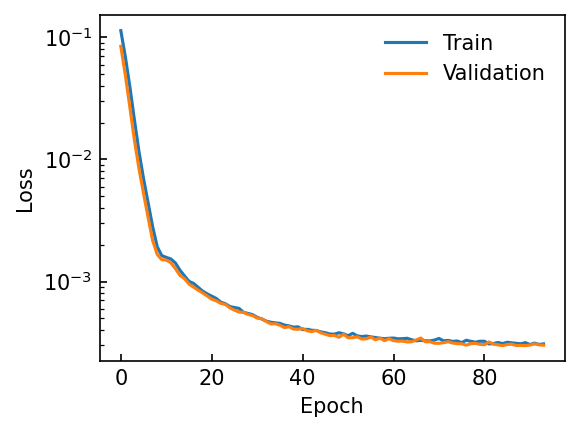

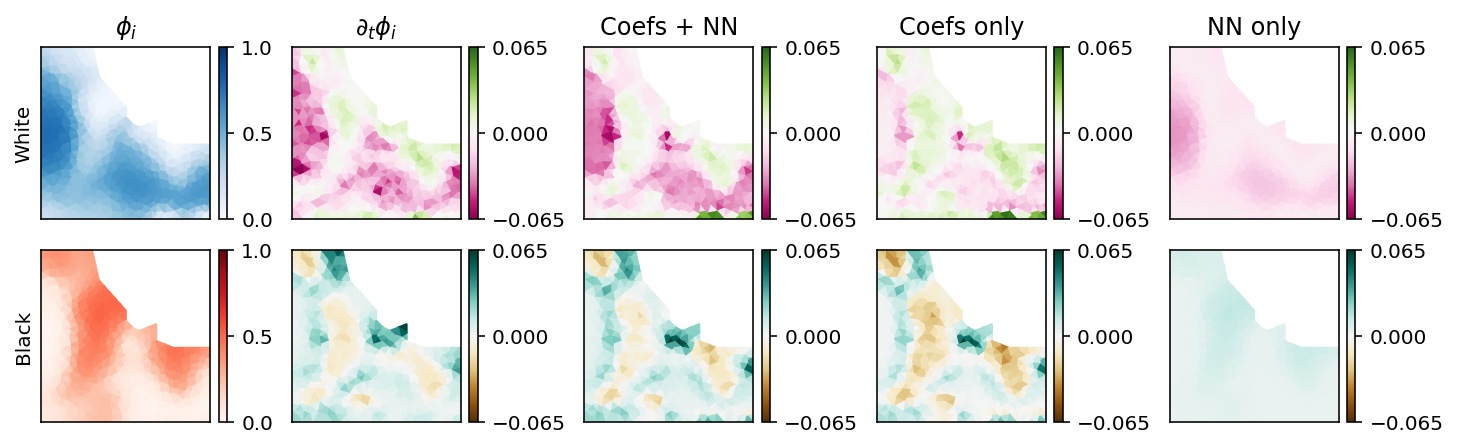

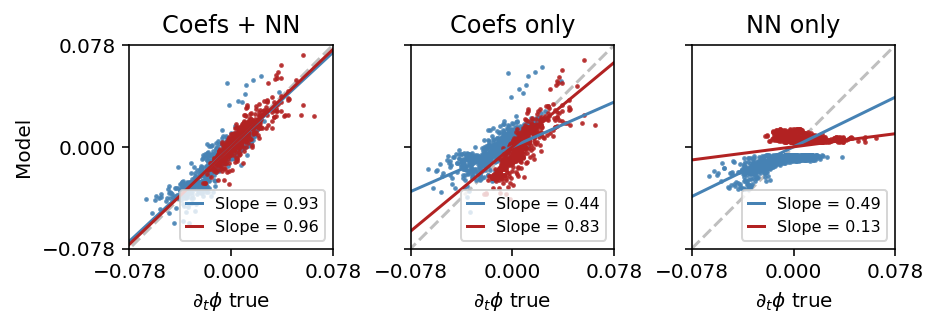

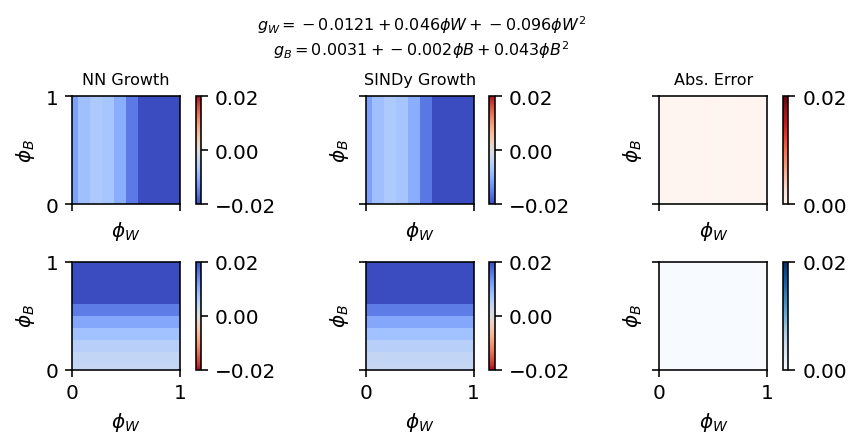

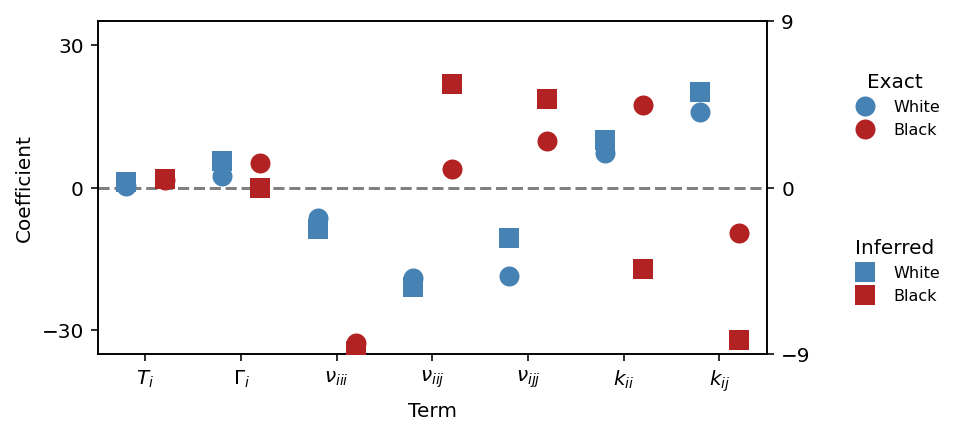

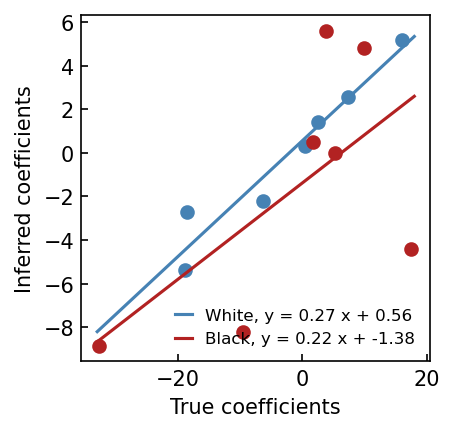

In [3]:
from fipy_analysis import analysis_pipeline

model = models[-1]
county = "_".join(model.split("/")[-1].split("_")[:2])

analysis_pipeline(model, county=county, printout=True)